In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time  # Import time module to track epoch duration

In [2]:
# Kiểm tra GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Đường dẫn thư mục
data_dir = 'CNN_MultiClass_data'

In [4]:
# Phép biến đổi hình ảnh
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize ảnh về kích thước 150x150
    transforms.ToTensor(),  # Chuyển ảnh về dạng tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])  # Chuẩn hóa ảnh theo mean và std của ImageNet

In [5]:
# Tạo dataset và dataloader
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'animals'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
# Tạo mô hình ResNet50 pre-trained
def gen_model():
    weights = models.ResNet50_Weights.DEFAULT  # Lấy các trọng số mặc định đã được huấn luyện trên tập dữ liệu ImageNet của ResNet50.
    model = models.resnet50(
        weights=weights)  # Tạo mô hình ResNet50 và tải các trọng số pre-trained. Nhờ vậy, mô hình đã học được các đặc trưng cơ bản như các cạnh, góc và hình dạng tổng quát từ dữ liệu ImageNet.

    # Đóng băng các lớp pre-trained 
    for param in model.parameters():
        param.requires_grad = False

    # Thay đổi lớp Fully Connected để phù hợp với số lớp đầu ra (3 lớp)
    num_features = model.fc.in_features  # Lấy số lượng đặc trưng (features) đầu vào của lớp Fully Connected hiện tại. Đối với ResNet50, giá trị này là 2048

    # Thay thế lớp Fully Connected cuối cùng bằng một mạng Sequential mới
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 3)  # Lớp Linear cuối cùng có đầu ra là 3, tương ứng với 3 lớp cần phân loại trong bài toán.
    )

    return model

In [7]:
model = gen_model().to(device)

In [8]:
# In kiến trúc của mô hình để kiểm tra
print('Model architecture')
print(model)

Model architecture
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=

In [9]:
# Huấn luyện mô hình
def train_test_resnet(model, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    for epoch in range(epochs):
        start_time = time.time()  # Start timer for the epoch

        # Training phase
        model.train()
        train_loss, train_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels.data)

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc.item())
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.item())

        end_time = time.time()  # End timer for the epoch
        epoch_time = end_time - start_time  # Calculate elapsed time for the epoch

        print(f"Epoch {epoch + 1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | "
              f"Epoch Time: {epoch_time:.2f} seconds")  # Print epoch time

    # Vẽ đồ thị
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc_history, label='Training Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

Epoch 1/10 | Train Loss: 0.1458 Acc: 0.9500 | Val Loss: 0.0201 Acc: 0.9957 | Epoch Time: 26.60 seconds
Epoch 2/10 | Train Loss: 0.0456 Acc: 0.9820 | Val Loss: 0.0168 Acc: 0.9930 | Epoch Time: 24.62 seconds
Epoch 3/10 | Train Loss: 0.0384 Acc: 0.9867 | Val Loss: 0.0063 Acc: 0.9990 | Epoch Time: 24.66 seconds
Epoch 4/10 | Train Loss: 0.0164 Acc: 0.9957 | Val Loss: 0.0063 Acc: 0.9977 | Epoch Time: 24.82 seconds
Epoch 5/10 | Train Loss: 0.0227 Acc: 0.9943 | Val Loss: 0.0026 Acc: 1.0000 | Epoch Time: 24.96 seconds
Epoch 6/10 | Train Loss: 0.0143 Acc: 0.9953 | Val Loss: 0.0022 Acc: 0.9990 | Epoch Time: 25.00 seconds
Epoch 7/10 | Train Loss: 0.0123 Acc: 0.9963 | Val Loss: 0.0009 Acc: 1.0000 | Epoch Time: 25.19 seconds
Epoch 8/10 | Train Loss: 0.0157 Acc: 0.9953 | Val Loss: 0.0012 Acc: 0.9997 | Epoch Time: 24.96 seconds
Epoch 9/10 | Train Loss: 0.0195 Acc: 0.9927 | Val Loss: 0.0049 Acc: 0.9983 | Epoch Time: 25.06 seconds
Epoch 10/10 | Train Loss: 0.0244 Acc: 0.9917 | Val Loss: 0.0200 Acc: 0.99

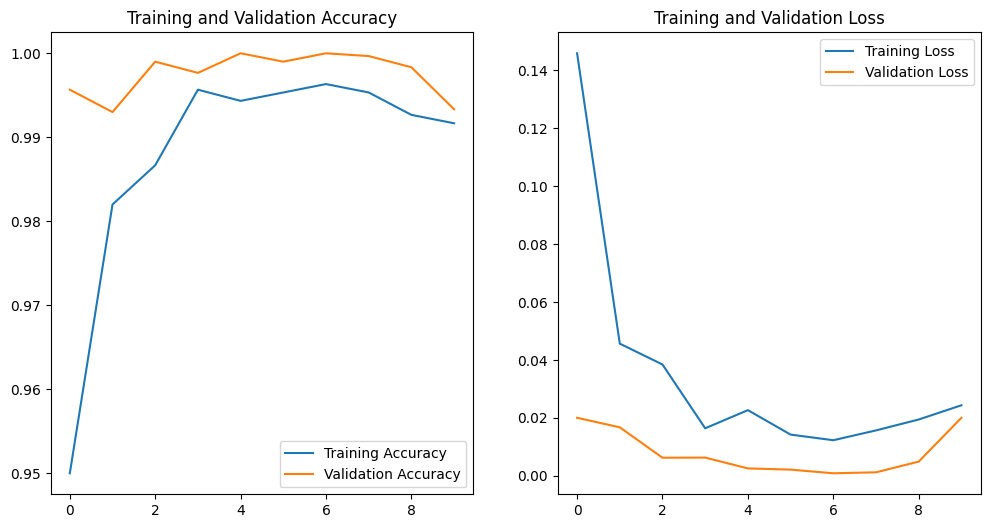

In [10]:
# Huấn luyện và kiểm tra mô hình
train_test_resnet(model, train_loader, val_loader, epochs=10)